In [1]:
import glob
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import os

# update the date_folder
folder = "KC_AWS/"
date_folder = "2021/09/01/"
files = "*.csv"

path = r"/Users/vivek/Google Drive/Dravam_Vivek/Data/KC_AWS/*.csv"
path = r"/Users/jufri/Google Drive/Dravam/TS_datavis/KC_AWS/*.csv"
path = r"/Users/jufri/Google Drive/Dravam/TS_datavis/KC_AWS/2021/09/05/*.csv"
path = folder+date_folder+files

header_list = [
   "time", "date_year", "date_month", "date_day", 
   "time_hr", "time_min", "time_sec", "time_Msec", 
   "pt_0001_load_value", "tt_0001_load_value", # pressure, temp
   "dp_0001_load_value", "dp_0001_unload_value", # diff pressure low 0-2000, high 0-5000
   "dp_0002_load_value", "dp_0002_unload_value",
   ]

variable_list=[
   "pt_0001_load_value", "tt_0001_load_value", 
   "dp_0001_load_value", "dp_0001_unload_value",
   "dp_0002_load_value", "dp_0002_unload_value"
]

# for fname in glob.glob(path):
#    print(fname)
# extension = 'csv'
# all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
# print(all_filenames)

all_filenames = [i for i in glob.glob(path)]
all_filenames = sorted(all_filenames)
all_filenames = all_filenames[:]
# for fname in glob.glob(path):
#    print(fname)

# #combine all files in the list
df_day_combined = pd.concat([pd.read_csv(f, names=header_list) for f in all_filenames ])
# df_day_combined
# #export to csv
# df_day_combined.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')

ValueError: No objects to concatenate

In [ ]:
df_day_combined=df_day_combined[["time"]+variable_list]

In [3]:
df_day_combined['time'] = pd.to_datetime(df_day_combined['time'], format='%Y-%m-%d %H:%M:%S.%f')
df_day_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 864001 entries, 0 to 5999
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   time                  864001 non-null  datetime64[ns]
 1   pt_0001_load_value    864001 non-null  float64       
 2   tt_0001_load_value    864001 non-null  float64       
 3   dp_0001_load_value    864001 non-null  float64       
 4   dp_0001_unload_value  864001 non-null  float64       
 5   dp_0002_load_value    864001 non-null  float64       
 6   dp_0002_unload_value  864001 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 52.7 MB


In [4]:
df_events=pd.DataFrame()
df_loading_events_time=pd.DataFrame()
df_unloading_events_time=pd.DataFrame()

In [5]:
# sort combined data by time
df_day_combined=df_day_combined.sort_values(by='time', ascending=True)

In [6]:
# 1 sec - 10 datapoints
# 3000 points = 300 secs = 5 min
# 6000 points = 600 secs = 10 min
# 15 mins = 900 secs = 9000 datapoints
# 20 mins = 1200 secs = 12000 datapoints

# rolling window for mean
r_window=9000
# duration how long an event should be
event_duration_threshold=12000

df_day_combined["dp_0001_load_value_mean"]=df_day_combined["dp_0001_load_value"].rolling(r_window, min_periods=1).mean()
df_day_combined["dp_0002_load_value_mean"]=df_day_combined["dp_0002_load_value"].rolling(r_window, min_periods=1).mean()

df_day_combined['dp_0001_load_value_mean_future'] = df_day_combined['dp_0001_load_value'].shift(-r_window).rolling(r_window, min_periods = 0).mean()
df_day_combined['dp_0002_load_value_mean_future'] = df_day_combined['dp_0002_load_value'].shift(-r_window).rolling(r_window, min_periods = 0).mean()

df_day_combined["dp_0001_unload_value_mean"]=df_day_combined["dp_0001_unload_value"].rolling(r_window, min_periods=1).mean()
df_day_combined["dp_0002_unload_value_mean"]=df_day_combined["dp_0002_unload_value"].rolling(r_window, min_periods=1).mean()

df_day_combined['dp_0001_unload_value_mean_future'] = df_day_combined['dp_0001_unload_value'].shift(-r_window).rolling(r_window, min_periods = 0).mean()
df_day_combined['dp_0002_unload_value_mean_future'] = df_day_combined['dp_0002_unload_value'].shift(-r_window).rolling(r_window, min_periods = 0).mean()


In [7]:
# placeholder for ML algorithm

def getEvent(
    dp_0001_load_value_mean, dp_0002_load_value_mean, dp_0001_load_value_mean_future, dp_0002_load_value_mean_future,
    dp_0001_unload_value_mean, dp_0002_unload_value_mean, dp_0001_unload_value_mean_future, dp_0002_unload_value_mean_future,
    pt_0001_load_value):
    
    max_load = max(dp_0001_load_value_mean, dp_0002_load_value_mean, dp_0001_load_value_mean_future, dp_0002_load_value_mean_future)
    max_unload = max(dp_0001_unload_value_mean, dp_0002_unload_value_mean, dp_0001_unload_value_mean_future, dp_0002_unload_value_mean_future)

    if max_load > 50 and max_load > max_unload and pt_0001_load_value < 1:
        return "L"
    elif max_unload > 50 and max_unload > max_load and pt_0001_load_value > 1:
        return "U"
    else:
        return "O"

df_day_combined["event"]=df_day_combined.apply(lambda x: 
    "Loading" 
    if getEvent(
        x.dp_0001_load_value_mean, x.dp_0002_load_value_mean, x.dp_0001_load_value_mean_future, x.dp_0002_load_value_mean_future,
        x.dp_0001_unload_value_mean, x.dp_0002_unload_value_mean, x.dp_0001_unload_value_mean_future, x.dp_0002_unload_value_mean_future,
        x.pt_0001_load_value)=="L"
    else ("Unloading" if (getEvent(
        x.dp_0001_load_value_mean, x.dp_0002_load_value_mean, x.dp_0001_load_value_mean_future, x.dp_0002_load_value_mean_future,
        x.dp_0001_unload_value_mean, x.dp_0002_unload_value_mean, x.dp_0001_unload_value_mean_future, x.dp_0002_unload_value_mean_future,
        x.pt_0001_load_value))=="U" else "" )
    , axis=1
)

In [8]:
# # check for events
# print(df_day_combined[df_day_combined["event"]=='Loading'])
# print(df_day_combined[df_day_combined["event"]=='Unloading'])

In [9]:
# group consecutive events
df_day_combined["event_grp"]=(df_day_combined.event != df_day_combined.event.shift()).cumsum()
df_day_combined.head()

time  pt_0001_load_value  tt_0001_load_value  \
0 2021-09-01 00:08:17.280540                 0.0           32.437500   
1 2021-09-01 00:08:17.374290                 0.0           32.437500   
2 2021-09-01 00:08:17.483665                 0.0           32.443748   
3 2021-09-01 00:08:17.577414                 0.0           32.443748   
4 2021-09-01 00:08:17.671164                 0.0           32.437500   

   dp_0001_load_value  dp_0001_unload_value  dp_0002_load_value  \
0                 0.0                28.500                 0.0   
1                 0.0                29.625                 0.0   
2                 0.0                30.500                 0.0   
3                 0.0                30.750                 0.0   
4                 0.0                31.000                 0.0   

   dp_0002_unload_value  dp_0001_load_value_mean  dp_0002_load_value_mean  \
0                   0.0                      0.0                      0.0   
1                   0.0                      0.0                      0.0   
2                   0.0                      0.0                      0.0   
3                   0.0                      0.0                      0.0   
4                   0.0                      0.0                      0.0   

   dp_0001_load_value_mean_future  dp_0002_load_value_mean_future  \
0                             0.0                             0.0   
1                             0.0                             0.0   
2                             0.0                             0.0   
3                             0.0                             0.0   
4                             0.0                             0.0   

   dp_0001_unload_value_mean  dp_0002_unload_value_mean  \
0                  28.500000                        0.0   
1                  29.062500                        0.0   
2                  29.541667                        0.0   
3                  29.843750                        0.0   
4                  30.075000                        0.0   

   dp_0001_unload_value_mean_future  dp_0002_unload_value_mean_future event  \
0                         25.500000                               0.0         
1                         28.187500                               0.0         
2                         30.041667                               0.0         
3                         32.187500                               0.0         
4                         33.850000                               0.0         

   event_grp  
0          1  
1          1  
2          1  
3          1  
4          1

In [10]:
# df_day_combined.groupby(['event_grp']).agg(lambda x:x.value_counts().index[0])


In [11]:
# get min (start time) and max (end time) of each event group
df_loading=df_day_combined[df_day_combined["event"]=="Loading"].groupby("event_grp").agg({'time': [("Start Time",np.min),("End Time",np.max),("Count",np.count_nonzero)]})
df_unloading=df_day_combined[df_day_combined["event"]=="Unloading"].groupby("event_grp").agg({'time': [("Start Time",np.min),("End Time",np.max),("Count",np.count_nonzero)]})
print(df_loading)
print(df_unloading)

                                time                                  
                          Start Time                   End Time  Count
event_grp                                                             
2         2021-09-01 13:32:10.269771 2021-09-01 15:58:53.283813  88032
4         2021-09-01 19:05:37.685040 2021-09-01 20:05:34.684392  35971
                                time                                 
                          Start Time                   End Time Count
event_grp                                                            
6         2021-09-01 20:15:33.684284 2021-09-01 20:15:39.481158    59


In [12]:

df_loading_events_time["Start Time"]=df_loading["time"]["Start Time"]
df_loading_events_time["End Time"]=df_loading["time"]["End Time"]
df_loading_events_time["Count"]=df_loading["time"]["Count"]
df_loading_events_time["Event"]=df_loading_events_time["Count"].apply(lambda x: "Loading" if x >= event_duration_threshold else "Outlier")
df_loading_events_time

Start Time                   End Time  Count    Event
2 2021-09-01 13:32:10.269771 2021-09-01 15:58:53.283813  88032  Loading
4 2021-09-01 19:05:37.685040 2021-09-01 20:05:34.684392  35971  Loading

In [13]:

df_unloading_events_time["Start Time"]=df_unloading["time"]["Start Time"]
df_unloading_events_time["End Time"]=df_unloading["time"]["End Time"]
df_unloading_events_time["Count"]=df_unloading["time"]["Count"]
df_unloading_events_time["Event"]=df_unloading_events_time["Count"].apply(lambda x: "Unloading" if x >= event_duration_threshold else "Outlier")
df_unloading_events_time

Start Time                   End Time  Count    Event
6 2021-09-01 20:15:33.684284 2021-09-01 20:15:39.481158     59  Outlier

In [14]:
# 1 sec - 10 datapoints
# 3000 points = 300 secs = 5 min
# 15 mins = 900 secs = 9000 datapoints
# 20 mins = 1200 secs = 12000 datapoints

df_events = pd.concat([df_loading_events_time, df_unloading_events_time])
df_events=df_events.sort_values(by='Start Time', ascending=True)
df_events["event_seconds"]=df_events["Count"]/10
df_events["event_minutes"]=df_events["Count"]/10/60
df_events["event_hour"]=df_events["Count"]/10/60/60
df_events

Start Time                   End Time  Count    Event  \
2 2021-09-01 13:32:10.269771 2021-09-01 15:58:53.283813  88032  Loading   
4 2021-09-01 19:05:37.685040 2021-09-01 20:05:34.684392  35971  Loading   
6 2021-09-01 20:15:33.684284 2021-09-01 20:15:39.481158     59  Outlier   

   event_seconds  event_minutes  event_hour  
2         8803.2     146.720000    2.445333  
4         3597.1      59.951667    0.999194  
6            5.9       0.098333    0.001639

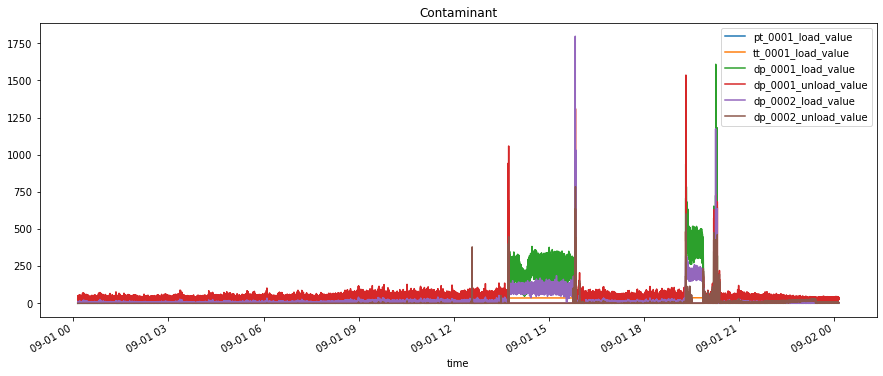

In [15]:
df_day_combined[["time"]+variable_list].plot(x='time', title='Contaminant', figsize=(15, 6));

In [16]:
# # ax = df.plot()
# ax = df_day_combined[["time"]+variable_list].plot(x='time', title='Contaminant', figsize=(15, 6));
# # Getting the boundaries for dates in feb and march
# # period = df_day_combined[(df_day_combined.index.month > 1) & (df_day_combined.index.month < 3)].index
# # Highlighting
# ax.axvspan("2021-09-12 00:08:17.279158", "2021-09-12 03:46:01.683056",
#            facecolor='g', edgecolor='none', alpha=.2)

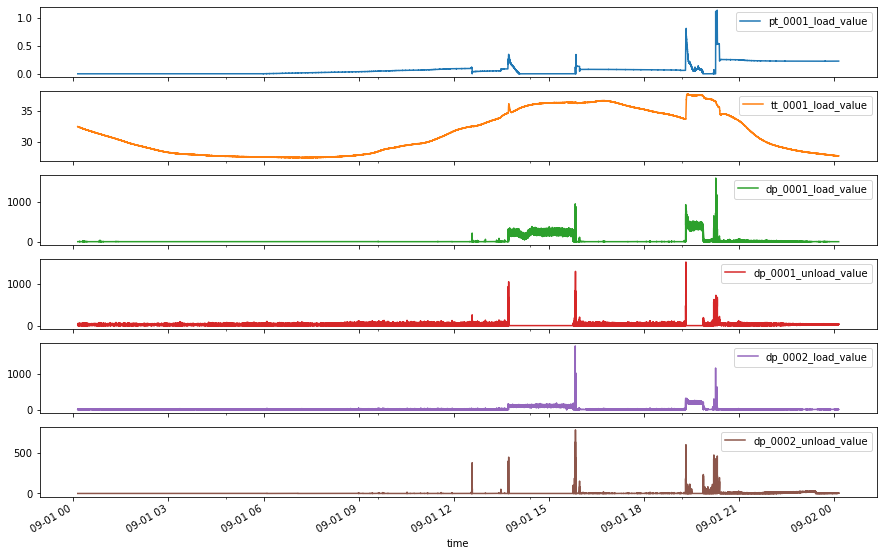

In [17]:
# Plot each feature on own axis for clearer view of any pattern
df_day_combined[["time"]+variable_list].plot(x='time',subplots=True, sharex=True, figsize=(15,10))

# plt.show()
plt.savefig("exported_images/"+date_folder.replace("/","")+'.png',facecolor='white', transparent=False)

In [18]:
# axes = df_day_combined[["time"]+variable_list].plot(x='time',subplots=True, sharex=True, figsize=(15,10))
# axes
# # for (ax,), col in zip(axes, df_day_combined[["time"]+variable_list].columns):
# #     ax.axvspan("2021-09-05 10:48:01.397020", "2021-09-05 12:48:01.397020", color='c', alpha=0.5)
# #     ax.axvspan("2021-09-12 08:53:12.179739", "2021-09-12 12:02:10.880823", color='orange', alpha=0.5)
# #     ax.set_title(col)

# # plt.tight_layout()
# # plt.style.use('seaborn-white')
# # plt.show()

In [19]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

shapes_list=[]

for x in range(df_events.shape[0]):
        
    if df_events["Event"].iloc[x]=="Loading":
        fillcolor="rgba(63, 81, 181, 0.2)" # blue
    elif df_events["Event"].iloc[x]=="Unloading":
        fillcolor="rgba(76, 175, 80, 0.1)" # green
    elif df_events["Event"].iloc[x]=="Outlier":
        fillcolor="rgba(181, 76, 80, 0.1)" # red
    else:
        fillcolor="rgba(255, 255, 255, 0.1)", # black

    shapes_list.append(dict(
            fillcolor=fillcolor,
            line={"width": 0},
            type="rect",
            # x0=df_loading["time"]["Start Time"].iloc[x],
            # x1=df_loading["time"]["End Time"].iloc[x],
            x0=df_events["Start Time"].iloc[x],
            x1=df_events["End Time"].iloc[x],
            xref="x",
            y0=0,
            y1=0.95,
            yref="paper"
        ))

shapes_list

[{'fillcolor': 'rgba(63, 81, 181, 0.2)',
  'line': {'width': 0},
  'type': 'rect',
  'x0': Timestamp('2021-09-01 13:32:10.269771'),
  'x1': Timestamp('2021-09-01 15:58:53.283813'),
  'xref': 'x',
  'y0': 0,
  'y1': 0.95,
  'yref': 'paper'},
 {'fillcolor': 'rgba(63, 81, 181, 0.2)',
  'line': {'width': 0},
  'type': 'rect',
  'x0': Timestamp('2021-09-01 19:05:37.685040'),
  'x1': Timestamp('2021-09-01 20:05:34.684392'),
  'xref': 'x',
  'y0': 0,
  'y1': 0.95,
  'yref': 'paper'},
 {'fillcolor': 'rgba(181, 76, 80, 0.1)',
  'line': {'width': 0},
  'type': 'rect',
  'x0': Timestamp('2021-09-01 20:15:33.684284'),
  'x1': Timestamp('2021-09-01 20:15:39.481158'),
  'xref': 'x',
  'y0': 0,
  'y1': 0.95,
  'yref': 'paper'}]

In [20]:
# plotly graph

fig = make_subplots(rows=6, cols=1, vertical_spacing=0.065, shared_xaxes=True)
fig.add_trace(
    go.Scatter(x=list(df_day_combined.time), y=list(df_day_combined.pt_0001_load_value), name="pt_0001_load_value"), 1, 1)
fig.add_trace(
    go.Scatter(x=list(df_day_combined.time), y=list(df_day_combined.tt_0001_load_value), name="tt_0001_load_value"), 2, 1)
fig.add_trace(
    go.Scatter(x=list(df_day_combined.time), y=list(df_day_combined.dp_0001_load_value), name="dp_0001_load_value"), 3, 1)
fig.add_trace(
    go.Scatter(x=list(df_day_combined.time), y=list(df_day_combined.dp_0001_unload_value), name="dp_0001_unload_value"), 4, 1)
fig.add_trace(
    go.Scatter(x=list(df_day_combined.time), y=list(df_day_combined.dp_0002_load_value), name="dp_0002_load_value"), 5, 1)
fig.add_trace(
    go.Scatter(x=list(df_day_combined.time), y=list(df_day_combined.dp_0002_unload_value), name="dp_0002_unload_value"), 6, 1);

# Add shapes
fig.update_layout(
    shapes=shapes_list
)

fig.update_layout(
    height=800,
    title_text="Bunkering Operation")


fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=[
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ]),
        type="date"),#end xaxis  definition
    
    xaxis6_rangeslider_visible=True,
    xaxis6_type="date"
    );
# fig.show()

fig.write_html("exported_html/"+date_folder.replace("/","")+".html")
# fig.write_image(date_folder+date_folder+"fig1.png")



In [21]:
df_day_combined

time  pt_0001_load_value  tt_0001_load_value  \
0    2021-09-01 00:08:17.280540             0.00000           32.437500   
1    2021-09-01 00:08:17.374290             0.00000           32.437500   
2    2021-09-01 00:08:17.483665             0.00000           32.443748   
3    2021-09-01 00:08:17.577414             0.00000           32.443748   
4    2021-09-01 00:08:17.671164             0.00000           32.437500   
...                         ...                 ...                 ...   
5995 2021-09-02 00:08:16.775521             0.22750           27.668751   
5996 2021-09-02 00:08:16.884896             0.22875           27.674999   
5997 2021-09-02 00:08:16.978647             0.22750           27.674999   
5998 2021-09-02 00:08:17.072396             0.22750           27.674999   
5999 2021-09-02 00:08:17.181772             0.22875           27.674999   

      dp_0001_load_value  dp_0001_unload_value  dp_0002_load_value  \
0                    0.0                28.500               0.000   
1                    0.0                29.625               0.000   
2                    0.0                30.500               0.000   
3                    0.0                30.750               0.000   
4                    0.0                31.000               0.000   
...                  ...                   ...                 ...   
5995                 0.0                38.625               0.000   
5996                 0.0                36.250               0.000   
5997                 0.0                34.875               0.000   
5998                 0.0                33.375               0.000   
5999                 0.0                30.375               0.625   

      dp_0002_unload_value  dp_0001_load_value_mean  dp_0002_load_value_mean  \
0                   0.0000                 0.000000                 0.000000   
1                   0.0000                 0.000000                 0.000000   
2                   0.0000                 0.000000                 0.000000   
3                   0.0000                 0.000000                 0.000000   
4                   0.0000                 0.000000                 0.000000   
...                    ...                      ...                      ...   
5995                5.9375                 0.004278                 1.767778   
5996                4.6875                 0.004278                 1.767535   
5997                4.3750                 0.004278                 1.767292   
5998                3.7500                 0.004278                 1.767049   
5999                3.1250                 0.004278                 1.766875   

      dp_0001_load_value_mean_future  dp_0002_load_value_mean_future  \
0                                0.0                        0.000000   
1                                0.0                        0.000000   
2                                0.0                        0.000000   
3                                0.0                        0.000000   
4                                0.0                        0.000000   
...                              ...                             ...   
5995                             0.0                        0.156250   
5996                             0.0                        0.208333   
5997                             0.0                        0.312500   
5998                             0.0                        0.625000   
5999                             NaN                             NaN   

      dp_0001_unload_value_mean  dp_0002_unload_value_mean  \
0                     28.500000                   0.000000   
1                     29.062500                   0.000000   
2                     29.541667                   0.000000   
3                     29.843750                   0.000000   
4                     30.075000                   0.000000   
...                         ...                        ...   
5995                  30.

In [24]:
# df_day_combined.between_time(df_events["Start Time"].iloc[0], df_events["End Time"].iloc[0])
df_day_combined.loc[(df_day_combined['time'] > df_events["Start Time"].iloc[0]) & (df_day_combined['time'] < df_events["End Time"].iloc[0])]


time  pt_0001_load_value  tt_0001_load_value  \
2331 2021-09-01 13:32:10.379146             0.08250           34.193748   
2332 2021-09-01 13:32:10.472897             0.08125           34.193748   
2333 2021-09-01 13:32:10.582271             0.08125           34.193748   
2334 2021-09-01 13:32:10.676021             0.08125           34.187500   
2335 2021-09-01 13:32:10.769771             0.08125           34.181252   
...                         ...                 ...                 ...   
355  2021-09-01 15:58:52.783812             0.07750           36.268749   
356  2021-09-01 15:58:52.877562             0.07625           36.268749   
357  2021-09-01 15:58:52.971315             0.07750           36.262501   
358  2021-09-01 15:58:53.080689             0.07750           36.262501   
359  2021-09-01 15:58:53.174437             0.07625           36.268749   

      dp_0001_load_value  dp_0001_unload_value  dp_0002_load_value  \
2331                 0.0                55.500                 0.0   
2332                 0.0                45.000                 0.0   
2333                 0.0                34.375                 0.0   
2334                 0.0                28.750                 0.0   
2335                 0.0                23.750                 0.0   
...                  ...                   ...                 ...   
355                  0.0                 0.000                 0.0   
356                  0.0                 0.000                 0.0   
357                  0.0                 0.000                 0.0   
358                  0.0                 0.000                 0.0   
359                  0.0                 0.000                 0.0   

      dp_0002_unload_value  dp_0001_load_value_mean  dp_0002_load_value_mean  \
2331                   0.0                 0.300153                 4.328854   
2332                   0.0                 0.300153                 4.328611   
2333                   0.0                 0.300153                 4.328368   
2334                   0.0                 0.300153                 4.328125   
2335                   0.0                 0.300153                 4.327882   
...                    ...                      ...                      ...   
355                    0.0                50.139667                25.793750   
356                    0.0                50.112361                25.784236   
357                    0.0                50.086819                25.775868   
358                    0.0                50.061417                25.767778   
359                    0.0                50.036528                25.759722   

      dp_0001_load_value_mean_future  dp_0002_load_value_mean_future  \
2331                       50.033889                       25.108993   
2332                       50.057833                       25.119757   
2333                       50.081056                       25.129722   
2334                       50.104222                       25.138785   
2335                       50.127417                       25.147708   
...                              ...                             ...   
355                         0.022000                        1.007118   
356                         0.022000                        1.007118   
357                         0.022000                        1.007118   
358                         0.022000                        1.007118   
359                         0.022000                        1.007118   

      dp_0001_unload_value_mean  dp_0002_unload_value_mean  \
2331                  27.013708                   0.193472   
2332                  27.017319                   0.193472   
2333                  27.019778                   0.193472   
2334                  27.021625                   0.193472   
2335                  27.022903                   0.193472   
...                         ...                        ...   
355                   42.